In [8]:
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
import matplotlib.pyplot as plt
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env.dummy_vec_env import DummyVecEnv
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize, SubprocVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_checker import check_env
import gym
import numpy as np
import time
from stable_baselines3.common.callbacks import EvalCallback
import env_test1
env = env_test1.DroneEnv()
check_env(env)
env = DummyVecEnv([lambda: env])

### 训练模型

In [10]:
# Evaluation callback
callbacks = []
eval_callback = EvalCallback(
    env,
    callback_on_new_best=None,
    n_eval_episodes=8,
    best_model_save_path=".",
    log_path=".",
    eval_freq=4000,
)

callbacks.append(eval_callback)
kwargs = {}
kwargs["callback"] = callbacks

log_name = "ppo_run_" + str(time.time())

In [2]:

#vec_env = VecNormalize(env, norm_obs=True, norm_reward=True,clip_obs=1)

model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="./tensorboard/",device="cuda")

model.learn(
    total_timesteps=800000,
    tb_log_name=log_name,
    **kwargs
)
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Before training: mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")
model.save("last_model")

Using cuda device
Logging to ./tensorboard/ppo_run_1713687832.6596043_1
-----------------------------
| time/              |      |
|    fps             | 817  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------


/root/miniconda3/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4000, episode_reward=-10835.17 +/- 9321.84
Episode length: 326.25 +/- 23.09
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 326          |
|    mean_reward          | -1.08e+04    |
| time/                   |              |
|    total_timesteps      | 4000         |
| train/                  |              |
|    approx_kl            | 0.0029642964 |
|    clip_fraction        | 0.0104       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 1.26e-05     |
|    learning_rate        | 0.0003       |
|    loss                 | 6.96e+05     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00491     |
|    std                  | 1            |
|    value_loss           | 1.47e+06     |
------------------------------------------
New best mean reward!
-----------------------------
| time/              |      |
|    f

### 再训练

In [11]:
del model
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="./tensorboard/",device="cuda")
model.set_parameters("last_model")
model.learn(
    total_timesteps=200000,
    tb_log_name=log_name,
    **kwargs
)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./tensorboard/ppo_run_1713689561.763529_1
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 352       |
|    ep_rew_mean     | -2.04e+03 |
| time/              |           |
|    fps             | 858       |
|    iterations      | 1         |
|    time_elapsed    | 2         |
|    total_timesteps | 2048      |
----------------------------------
Eval num_timesteps=4000, episode_reward=-1569.59 +/- 155.36
Episode length: 316.62 +/- 26.49
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 317          |
|    mean_reward          | -1.57e+03    |
| time/                   |              |
|    total_timesteps      | 4000         |
| train/                  |              |
|    approx_kl            | 0.0058822203 |
|    clip_fraction        | 0.0557       |
|    clip_range       

### 绘图检验

Episode 1 total reward: -2062.3142465040733
Episode 2 total reward: -10985.751324923982
Episode 3 total reward: -2078.7413577303773
Episode 4 total reward: -19475.349703063184
Episode 5 total reward: -1900.8387239426065
Episode 6 total reward: -6478.355662527488
Episode 7 total reward: -12652.29847841948
Episode 8 total reward: -1639.8355671203385
Episode 9 total reward: -1548.4761987104637
Episode 10 total reward: -6382.508278333867


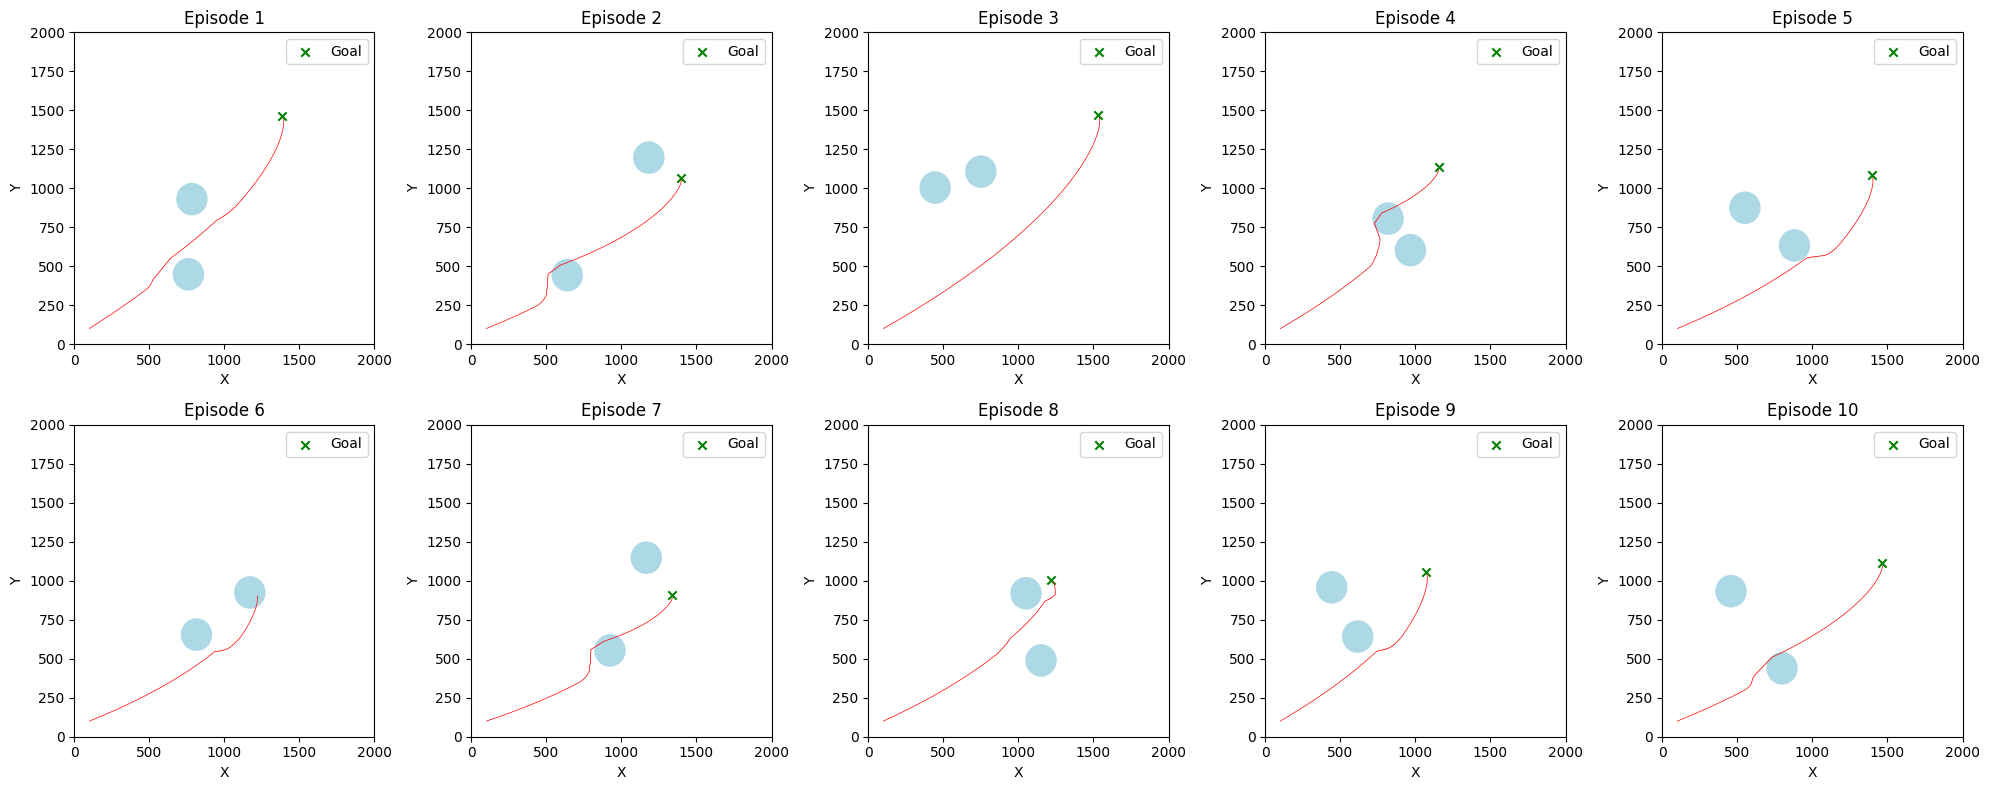

In [19]:
import matplotlib.pyplot as plt

# 创建一个包含10个子图的窗口
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
axs = axs.ravel()  # 将二维数组展平，方便通过索引访问每个子图

env = env_test1.DroneEnv()
for i in range(10):
    # 重置环境
    state, info = env.reset()
    trajectory_x = [env.xy_p[0]]  # 存储无人机路径的x坐标
    trajectory_y = [env.xy_p[1]]  # 存储无人机路径的y坐标
    trajectory_ex = [env.xy_e[0]]  # 存储无人机路径的x坐标
    trajectory_ey = [env.xy_e[1]]  # 存储无人机路径的y坐标
    
    # 在第i个子图中绘制环境和障碍物
    axs[i].scatter(env.xy_e[0], env.xy_e[1], marker='x', color='green', label='Goal')
    for k in env.obstacles:
        obstacle_circle = plt.Circle(k, env.r_obstacles, color='lightblue', fill=True)
        axs[i].add_patch(obstacle_circle)
    axs[i].set_xlim(env.space1.low[0], env.space1.high[0])
    axs[i].set_ylim(env.space1.low[1], env.space1.high[1])
    axs[i].set_xlabel('X')
    axs[i].set_ylabel('Y')
    axs[i].legend()
    axs[i].set_title(f'Episode {i+1}')

    # 通过预训练模型控制无人机执行任务并绘制路径
    model = PPO.load("best_model") 
    done = False
    total_reward = 0
    count = 0
    while not done:
        count += 1
        action, _states = model.predict(state, deterministic=True)
        next_state, reward, done, t, info = env.step(action)
        #if reward < -10:
            #print(state, action, reward)
        if count > 500:
            done = True
        total_reward += reward
        state = next_state
        trajectory_x.append(env.xy_p[0])  # 更新无人机路径的x坐标
        trajectory_y.append(env.xy_p[1])  # 更新无人机路径的y坐标
        trajectory_ex.append(env.xy_e[0])  # 更新无人机路径的x坐标
        trajectory_ey.append(env.xy_e[1])  # 更新无人机路径的y坐标

    # 绘制无人机路径
    axs[i].plot(trajectory_x, trajectory_y, color='red', linewidth=0.5)
    axs[i].plot(trajectory_ex, trajectory_ey, color='red', linewidth=0.5)

    # 打印每个episode的总奖励
    print(f'Episode {i+1} total reward:', total_reward)

# 显示子图窗口
plt.tight_layout()
plt.show()


In [ ]:
model.save("last_model")